In [2]:
import pandas as pd

# Replace with your actual filename
df = pd.read_csv('individual household electric power consumption dataset.Book1.csv')
df.head()


,Date,Time,Global_active_power,Voltage,Global_intensity
0,16-12-2006,17:24:00,4.216,234.84,18.4
1,16-12-2006,17:25:00,5.360,233.63,23.0
2,16-12-2006,17:26:00,5.374,233.29,23.0
3,16-12-2006,17:27:00,5.388,233.74,23.0
4,16-12-2006,17:28:00,3.666,235.68,15.8


In [3]:
# Fix column names if necessary
df.columns = ['Date', 'Time', 'Global_active_power', 'Voltage', 'Global_intensity']

# Combine Date + Time into one datetime column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Set datetime as index
df.set_index('Datetime', inplace=True)

# Drop old Date and Time
df.drop(['Date', 'Time'], axis=1, inplace=True)
df.sort_index(inplace=True)
df.head()


<ipython-input-3-2351976394>:5: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])


,Global_active_power,Voltage,Global_intensity
Datetime,,,
2006-12-16 17:24:00,4.216,234.84,18.4
2006-12-16 17:25:00,5.360,233.63,23.0
2006-12-16 17:26:00,5.374,233.29,23.0
2006-12-16 17:27:00,5.388,233.74,23.0
2006-12-16 17:28:00,3.666,235.68,15.8


Feature engineering

In [4]:
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)


In [5]:
df['lag_1'] = df['Global_active_power'].shift(1)
df['lag_2'] = df['Global_active_power'].shift(2)
df['lag_3'] = df['Global_active_power'].shift(3)


In [6]:
df['rolling_mean_3'] = df['Global_active_power'].rolling(window=3).mean()
df['rolling_std_3'] = df['Global_active_power'].rolling(window=3).std()


In [7]:
df['power_calc'] = df['Voltage'] * df['Global_intensity']


In [8]:
# Check data types and missing values

print("\n📊 Dataset Info:")

print(df.info())


# Summary statistics

print("\n📈 Descriptive Statistics:")

print(df.describe())


📊 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1048575 entries, 2006-12-16 17:24:00 to 2008-12-13 21:38:00
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Global_active_power  1044506 non-null  float64
 1   Voltage              1044506 non-null  float64
 2   Global_intensity     1044506 non-null  float64
 3   hour                 1048575 non-null  int32  
 4   day_of_week          1048575 non-null  int32  
 5   is_weekend           1048575 non-null  int64  
 6   lag_1                1044505 non-null  float64
 7   lag_2                1044504 non-null  float64
 8   lag_3                1044503 non-null  float64
 9   rolling_mean_3       1044427 non-null  float64
 10  rolling_std_3        1044427 non-null  float64
 11  power_calc           1044506 non-null  float64
dtypes: float64(9), int32(2), int64(1)
memory usage: 96.0 MB
None

📈 Descriptive Statistics:
       Global_ac

In [9]:
df.dropna(inplace=True)

In [10]:
#Define Features and Target
X = df.drop(['Global_active_power'], axis=1)
y = df['Global_active_power']

In [11]:
#Split Data Using TimeSeriesSplit
from sklearn.model_selection import train_test_split

# Use last 20% for testing (time-based split)
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [17]:
from sklearn.preprocessing import StandardScaler

# Create scaler instance
scaler = StandardScaler()

# Fit on training data and transform
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data
X_test_scaled = scaler.transform(X_test)


In [19]:
#Train Random Forest & XGBoost
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

rf.fit(X_train_scaled, y_train)
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [20]:
#Evaluate Models
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_model(model, X_test_scaled, y_test):
    pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    return mae, rmse, pred

rf_mae, rf_rmse, rf_pred = evaluate_model(rf, X_test_scaled, y_test)
xgb_mae, xgb_rmse, xgb_pred = evaluate_model(xgb, X_test_scaled, y_test)

print("Random Forest - MAE:", rf_mae, " RMSE:", rf_rmse)
print("XGBoost - MAE:", xgb_mae, " RMSE:", xgb_rmse)

Random Forest - MAE: 0.0065593302310440185  RMSE: 0.01796140664402497
XGBoost - MAE: 0.016779494369839207  RMSE: 0.026455764308228803


In [21]:
# Preserve datetime index before splitting
X = df.drop("Global_active_power", axis=1)
y = df["Global_active_power"]

# Save the index (datetime) to add it back later
original_datetime_index = X.index

# Split the data
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # Do not shuffle to retain chronological order

# The indices of X_test_scaled and y_test after the split are simple integers 0, 1, 2...
# We need to find the corresponding datetime values from the original index.
# Since shuffle=False, the test set corresponds to the last 20% of the original data.
split_index = len(X_train_scaled) # The index in the original dataset where the split occurred

# Add the correct datetime index back to the test set
X_test_scaled.index = original_datetime_index[split_index:]
y_test.index = original_datetime_index[split_index:]

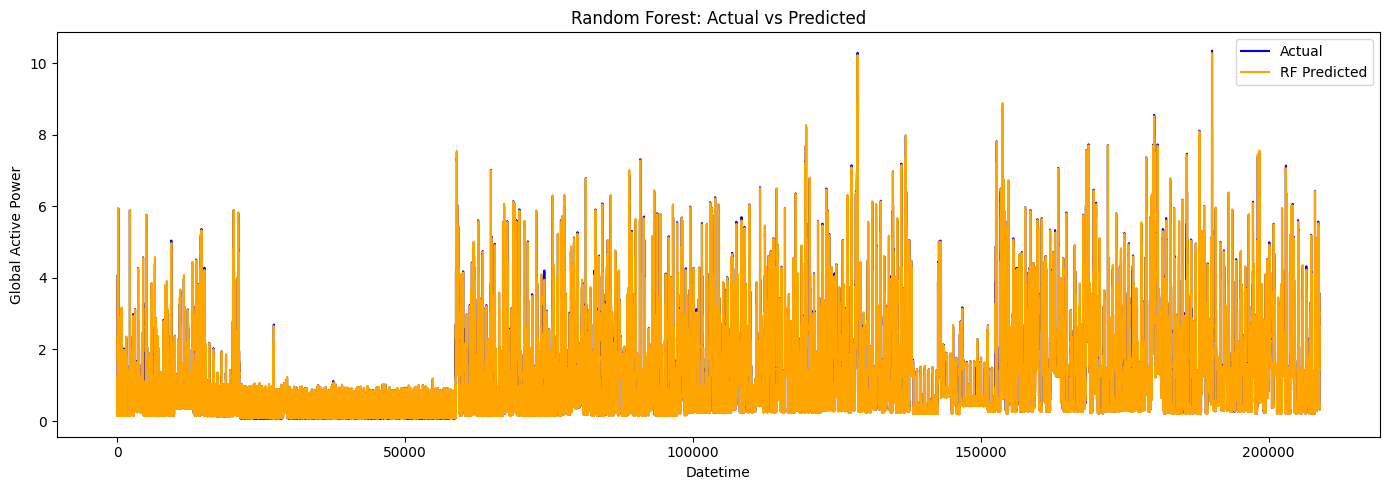

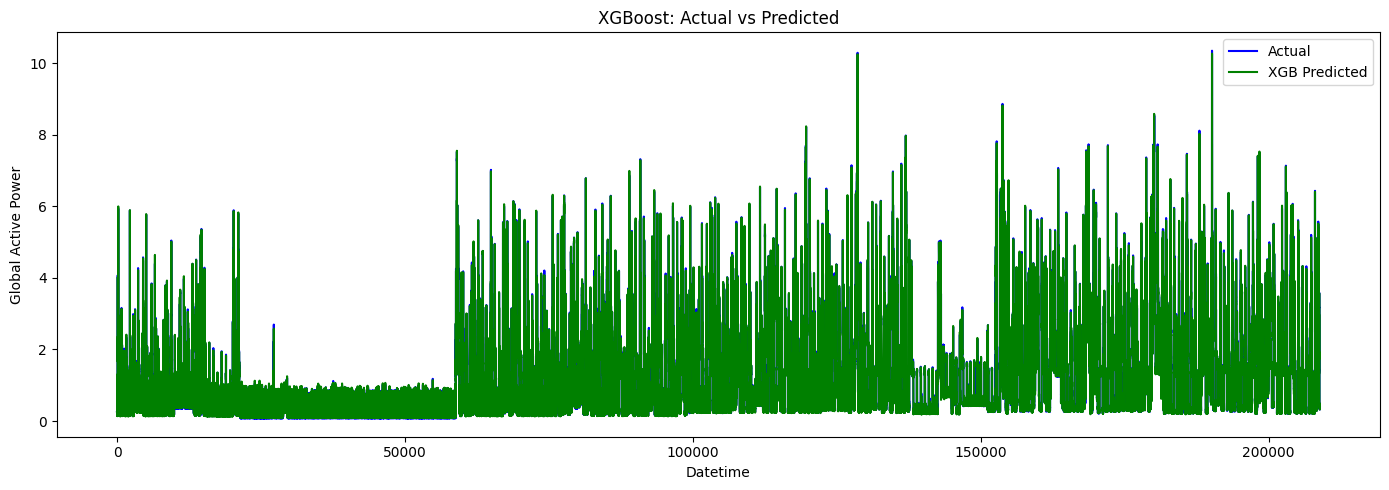

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# If y_test is a NumPy array, convert it to a DataFrame with datetime index (if available)
# Assuming you have a datetime series like `X_test_scaled_scaled .index` or similar
# If not, just use range(len(y_test))

# Replace this with your actual datetime series if available
datetime_index = X_test_scaled_scaled.index if hasattr(X_test_scaled_scaled , "index") else range(len(y_test))

# Create DataFrames
actual_df = pd.DataFrame({'Datetime': datetime_index, 'Actual': y_test})
rf_df = pd.DataFrame({'Datetime': datetime_index, 'RF Predicted': rf_pred})
xgb_df = pd.DataFrame({'Datetime': datetime_index, 'XGB Predicted': xgb_pred})

# ------------------- Random Forest Plot -------------------
plt.figure(figsize=(14,5))
plt.plot(actual_df['Datetime'], actual_df['Actual'], label='Actual', color='blue')
plt.plot(rf_df['Datetime'], rf_df['RF Predicted'], label='RF Predicted', color='orange')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power')
plt.title('Random Forest: Actual vs Predicted')
plt.legend()
plt.tight_layout()
plt.show()

# ------------------- XGBoost Plot -------------------
plt.figure(figsize=(14,5))
plt.plot(actual_df['Datetime'], actual_df['Actual'], label='Actual', color='blue')
plt.plot(xgb_df['Datetime'], xgb_df['XGB Predicted'], label='XGB Predicted', color='green')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power')
plt.title('XGBoost: Actual vs Predicted')
plt.legend()
plt.tight_layout()
plt.show()

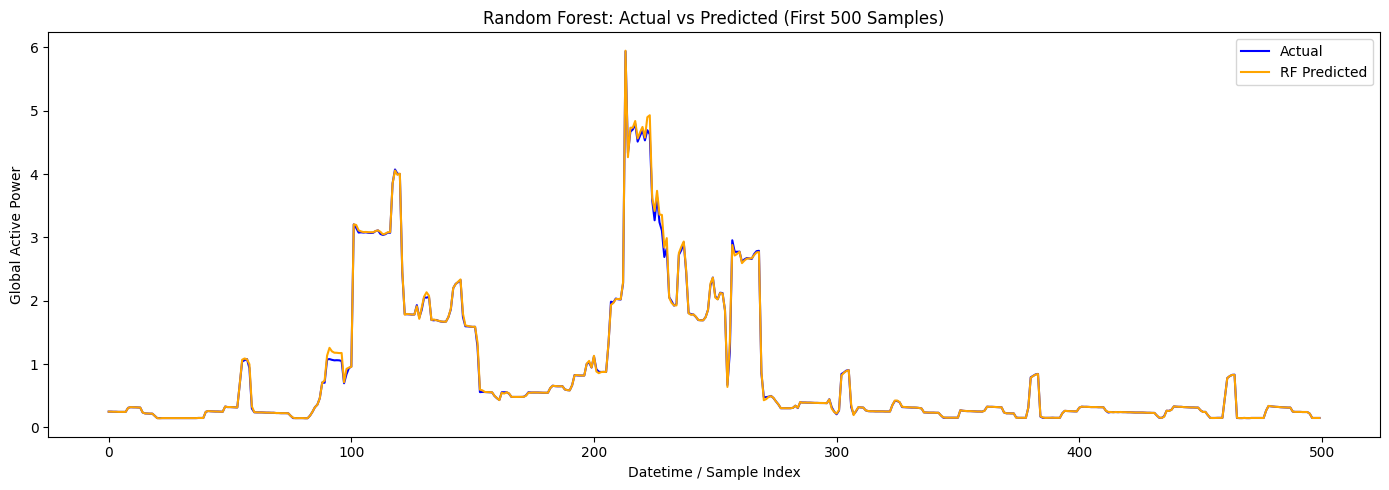

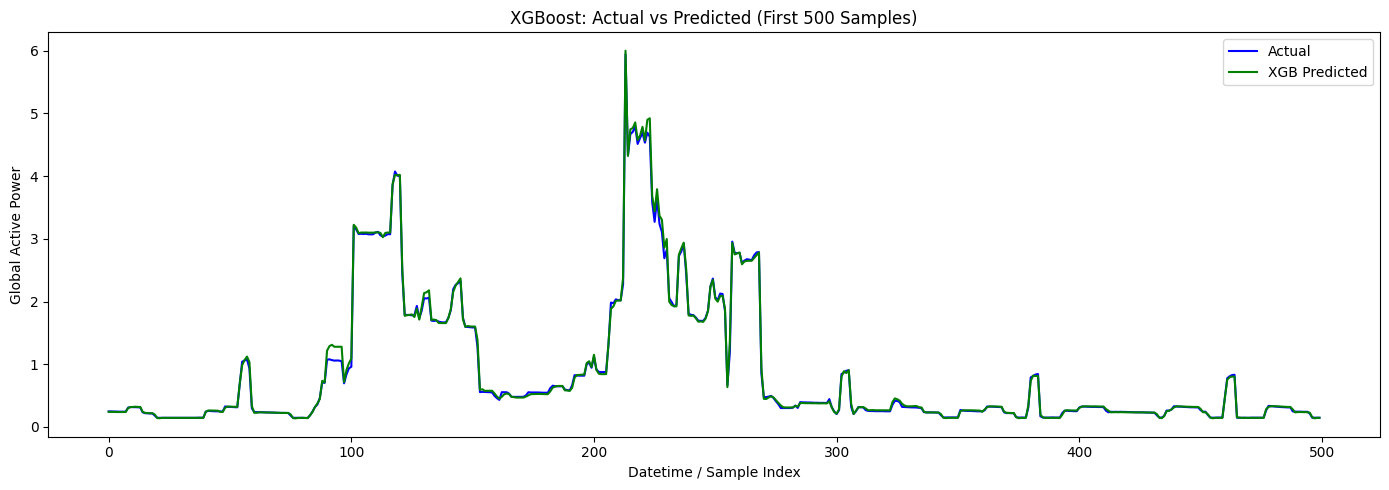

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure data is in Pandas DataFrame format
datetime_index = X_test_scaled_scaled.index if hasattr(X_test_scaled_scaled, "index") else range(len(y_test))

# Create DataFrames
actual_df = pd.DataFrame({'Datetime': datetime_index, 'Actual': y_test})
rf_df = pd.DataFrame({'Datetime': datetime_index, 'RF Predicted': rf_pred})
xgb_df = pd.DataFrame({'Datetime': datetime_index, 'XGB Predicted': xgb_pred})

# Slice the first 500 samples
actual_500 = actual_df.iloc[:500]
rf_500 = rf_df.iloc[:500]
xgb_500 = xgb_df.iloc[:500]

# ------------------- Random Forest Plot (First 500) -------------------
plt.figure(figsize=(14,5))
plt.plot(actual_500['Datetime'], actual_500['Actual'], label='Actual', color='blue')
plt.plot(rf_500['Datetime'], rf_500['RF Predicted'], label='RF Predicted', color='orange')
plt.xlabel('Datetime / Sample Index')
plt.ylabel('Global Active Power')
plt.title('Random Forest: Actual vs Predicted (First 500 Samples)')
plt.legend()
plt.tight_layout()
plt.show()

# ------------------- XGBoost Plot (First 500) -------------------
plt.figure(figsize=(14,5))
plt.plot(actual_500['Datetime'], actual_500['Actual'], label='Actual', color='blue')
plt.plot(xgb_500['Datetime'], xgb_500['XGB Predicted'], label='XGB Predicted', color='green')
plt.xlabel('Datetime / Sample Index')
plt.ylabel('Global Active Power')
plt.title('XGBoost: Actual vs Predicted (First 500 Samples)')
plt.legend()
plt.tight_layout()
plt.show()